In [1]:
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import boxcox1p, inv_boxcox
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor

from network_parser import *

2024-03-07 16:18:21.647816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 16:18:22.559714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Exploratory Data Analysis

### Data Loading & Encoding

In [2]:
data_filter = NetworkDataFilter(
    boards=['pynq-z2', 'zcu102', 'alveo-u200']
)
inputs, targets = simple_data_from_json(
    './datasets/complex/dataset-*.json',
    data_filter
)

print('Full Dataset')
print(f'Features: {inputs.shape}')
print(f'Targets: {targets.shape}')

cond = np.all(targets <= 200., axis=1)
inputs = inputs[cond]
targets = targets[cond]

# targets_mean = targets.mean()
# targets_std = targets.std()

# targets -= targets_mean
# targets /= targets_std

# targets = np.expand_dims(targets, axis=-1)

print('=' * 100)
print('Kept Dataset')
print(f'Features: {inputs.shape}')
print(f'Targets: {targets.shape}')

qualitative_feature_labels = [
    'strategy',
    'precision',
    'board',
]
quantitative_feature_labels = [
    'dense_count',
    'bn_count',
    'add_count',
    'concatenate_count',
    'dropout_count',
    'relu_count',
    'sigmoid_count',
    'tanh_count',
    'softmax_count',
    'avg_dense_params',
    'avg_dense_in',
    'avg_dense_out',
    'avg_dense_rf',
]
feature_labels = qualitative_feature_labels + quantitative_feature_labels
target_labels = [
    'bram',
    'dsp',
    'ff',
    'lut'
]

test_inputs, test_targets = simple_data_from_json(
    './datasets/complex/test_dataset.json',
    data_filter
)

Full Dataset
Features: (6309, 16)
Targets: (6309, 4)
Kept Dataset
Features: (3594, 16)
Targets: (3594, 4)


In [3]:
train_df = pd.concat([pd.DataFrame(inputs), pd.DataFrame(targets)], axis=1)
train_df.columns = feature_labels + target_labels

test_df = pd.concat([pd.DataFrame(test_inputs), pd.DataFrame(test_targets)], axis=1)
test_df.columns = feature_labels + target_labels

for label in quantitative_feature_labels:
    train_df[label] = pd.to_numeric(train_df[label], errors='coerce')
    test_df[label] = pd.to_numeric(test_df[label], errors='coerce')

org_train_quantitative = train_df[quantitative_feature_labels]
org_train_targets = train_df[target_labels]

org_test_quantitative = test_df[quantitative_feature_labels]
org_test_targets = test_df[target_labels]

print(train_df.shape)
train_df.head()

(3594, 20)


,strategy,precision,board,dense_count,bn_count,add_count,concatenate_count,dropout_count,relu_count,sigmoid_count,tanh_count,softmax_count,avg_dense_params,avg_dense_in,avg_dense_out,avg_dense_rf,bram,dsp,ff,lut
0,latency,"ap_fixed<8, 3>",pynq-z2,3,0,0,0,0,0,2,0,0,934.333333,34.666667,30.333333,8.000000,10.714286,0.000000,10.191729,99.716165
1,resource,"ap_fixed<8, 3>",zcu102,8,0,0,0,0,1,3,2,1,1292.625000,175.750000,58.625000,60.000000,6.030702,2.539683,10.764740,133.394264
2,resource,"ap_fixed<8, 4>",zcu102,5,0,0,0,0,2,1,0,2,1506.400000,73.600000,74.400000,32.000000,4.166667,10.476190,24.570928,61.888135
3,latency,"ap_fixed<8, 3>",zcu102,6,0,0,0,0,1,2,1,1,1845.333333,45.333333,40.833333,8.000000,2.741228,2.539683,3.511748,96.601722
4,latency,"ap_fixed<16, 6>",alveo-u200,7,0,0,0,0,1,1,2,1,853.428571,164.857143,42.000000,52.571429,0.555556,1.432749,3.652220,17.483844


In [4]:
def encode(frame, feature, target_cols):
    ordering = pd.DataFrame()
    ordering['Val'] = frame[feature].unique()
    ordering.index = ordering['Val']
    frame['TargetsMean'] = frame[target_cols].mean(axis=1)
    ordering['TargetsMean'] = frame[[feature, 'TargetsMean']].groupby(feature).mean()['TargetsMean']
    ordering = ordering.sort_values('TargetsMean')
    ordering['Order'] = range(1, ordering.shape[0] + 1)
    ordering = ordering['Order'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature + '_E'] = o
    
    return frame

qualitative_labels_encoded = []
for q in qualitative_feature_labels:
    train_df = encode(train_df, q, target_labels)
    test_df = encode(test_df, q, target_labels)
    qualitative_labels_encoded.append(q + '_E')

train_df.head()

,strategy,precision,board,dense_count,bn_count,add_count,concatenate_count,dropout_count,relu_count,sigmoid_count,...,avg_dense_out,avg_dense_rf,bram,dsp,ff,lut,TargetsMean,strategy_E,precision_E,board_E
0,latency,"ap_fixed<8, 3>",pynq-z2,3,0,0,0,0,0,2,...,30.333333,8.000000,10.714286,0.000000,10.191729,99.716165,30.155545,1.0,3.0,3.0
1,resource,"ap_fixed<8, 3>",zcu102,8,0,0,0,0,1,3,...,58.625000,60.000000,6.030702,2.539683,10.764740,133.394264,38.182347,2.0,3.0,2.0
2,resource,"ap_fixed<8, 4>",zcu102,5,0,0,0,0,2,1,...,74.400000,32.000000,4.166667,10.476190,24.570928,61.888135,25.275480,2.0,2.0,2.0
3,latency,"ap_fixed<8, 3>",zcu102,6,0,0,0,0,1,2,...,40.833333,8.000000,2.741228,2.539683,3.511748,96.601722,26.348595,1.0,3.0,2.0
4,latency,"ap_fixed<16, 6>",alveo-u200,7,0,0,0,0,1,1,...,42.000000,52.571429,0.555556,1.432749,3.652220,17.483844,5.781092,1.0,4.0,1.0


### Targets Distribution

/home/hamza/Projects/NN_stuff/env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4905: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))


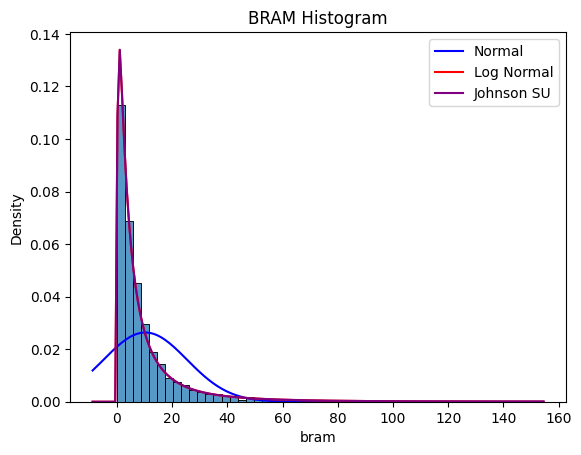

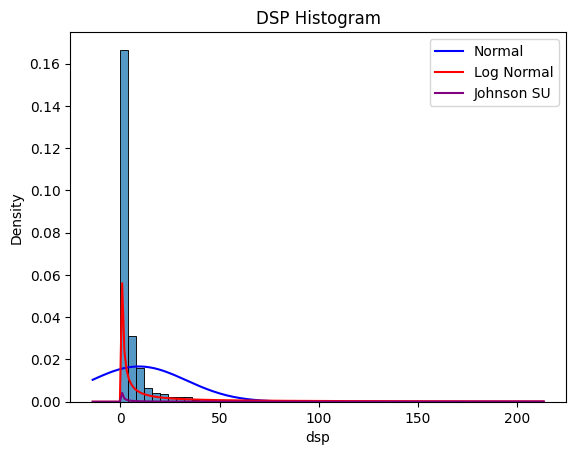

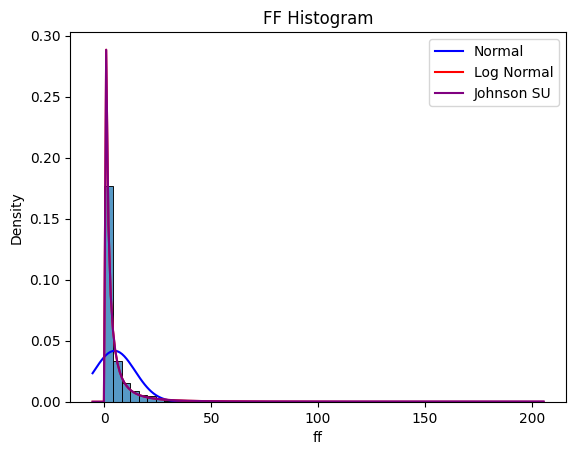

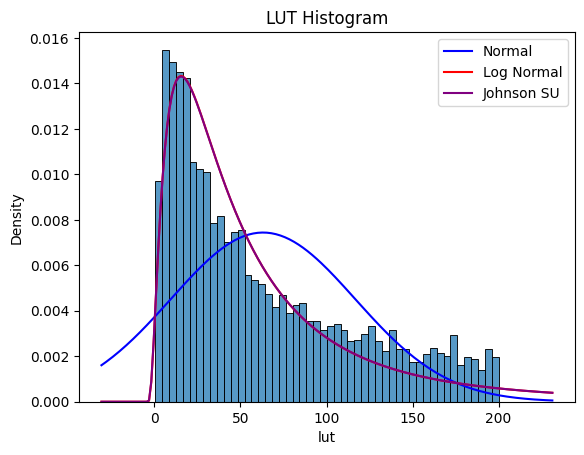

In [5]:
def add_fit_to_histplot(a, fit=stats.norm, ax=None, color='blue', label=None):
    if ax is None:
        ax = plt.gca()

    # Compute bandwidth
    bw = len(a)**(-1/5) * a.std(ddof=1)
    x = np.linspace(a.min()-bw*3, a.max()+bw*3, 200)
    params = fit.fit(a)
    y = fit.pdf(x, *params)
    ax.plot(x, y, color=color, label=label)
    return ax

train_df[target_labels] = org_train_targets
test_df[target_labels] = org_test_targets

for idx, label in enumerate(target_labels):
    plt.figure(idx)
    plt.title(f'{label.upper()} Histogram')
    ax = sns.histplot(train_df[label], bins=50, kde=False, stat='density')
    add_fit_to_histplot(train_df[label], fit=stats.norm, ax=ax, color='blue', label='Normal')
    add_fit_to_histplot(train_df[label], fit=stats.lognorm, ax=ax, color='red', label='Log Normal')
    add_fit_to_histplot(train_df[label], fit=stats.johnsonsu, ax=ax, color='purple', label='Johnson SU')
    plt.legend()

### Features Distribution

In [6]:
normal_test = lambda x, eps=0.01: stats.kstest(x, 'norm')[1] >= eps

normal = pd.DataFrame(train_df[quantitative_feature_labels])
normal = normal.apply(pd.to_numeric, errors='coerce')

normal_result = normal.apply(normal_test)
print(normal_result)

dense_count          False
bn_count             False
add_count            False
concatenate_count    False
dropout_count        False
relu_count           False
sigmoid_count        False
tanh_count           False
softmax_count        False
avg_dense_params     False
avg_dense_in         False
avg_dense_out        False
avg_dense_rf         False
dtype: bool


### Correlation

In [7]:
def spearman(frame, features, target_cols):
    for idx, target in enumerate(target_cols):
        spr = pd.DataFrame()
        spr['Feature'] = features
        spr['Correlation'] = [frame[f].corr(frame[target], 'spearman') for f in features]
        spr = spr.sort_values('Correlation')
        
        plt.figure(idx)
        plt.title(f'{target.upper()} Spearman')
        sns.barplot(data=spr, y='Feature', x='Correlation', orient='h')

# spearman(train_df, [f for f in train_df[quantitative_feature_labels + qualitative_labels_encoded].columns], target_labels)

<Axes: title={'center': 'Pearson Correlation'}>

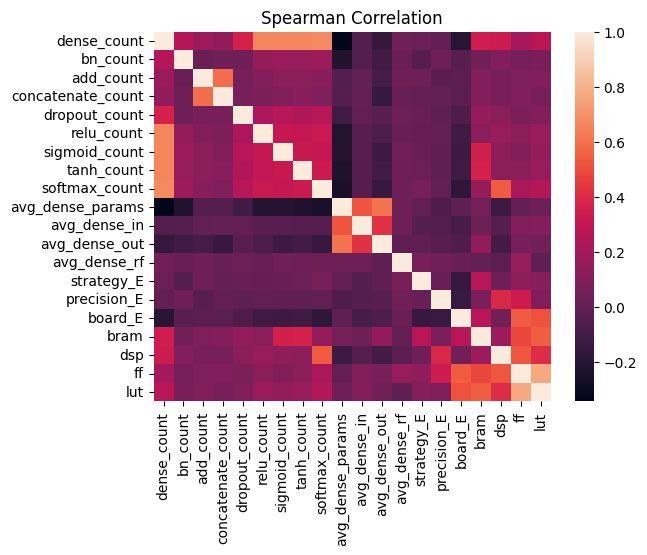

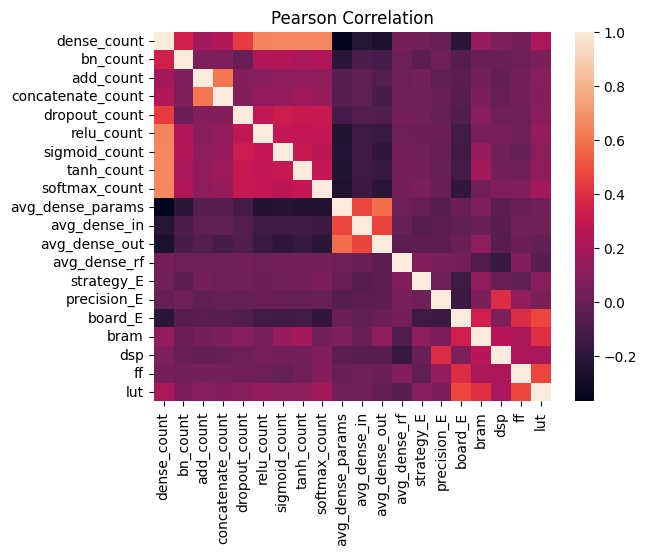

In [8]:
plt.figure(1)
plt.title('Spearman Correlation')
spearman_corr = train_df[quantitative_feature_labels + qualitative_labels_encoded + target_labels].corr(method='spearman')
sns.heatmap(spearman_corr)

plt.figure(2)
plt.title('Pearson Correlation')
pearson_corr = train_df[quantitative_feature_labels + qualitative_labels_encoded + target_labels].corr(method='pearson')
sns.heatmap(pearson_corr)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3594 samples in 0.001s...
[t-SNE] Computed neighbors for 3594 samples in 0.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3594
[t-SNE] Computed conditional probabilities for sample 2000 / 3594
[t-SNE] Computed conditional probabilities for sample 3000 / 3594
[t-SNE] Computed conditional probabilities for sample 3594 / 3594
[t-SNE] Mean sigma: 13.617504
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.288879
[t-SNE] KL divergence after 1000 iterations: 0.965138


/home/hamza/Projects/NN_stuff/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[0.24071771 0.10450233 0.09099292 0.07525238 0.06678979 0.06246984
 0.05855098 0.04633685]
0.7456128017100145


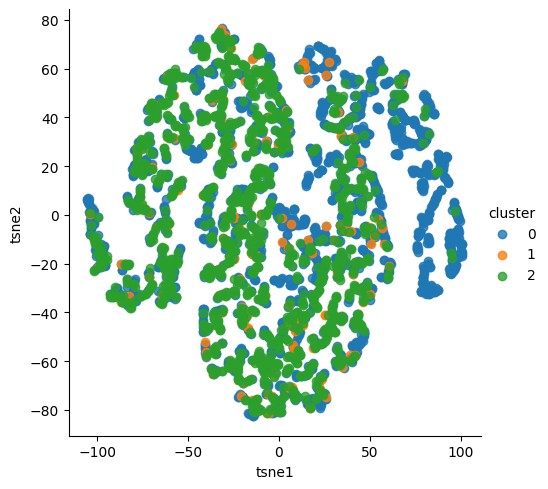

In [9]:
features = quantitative_feature_labels + qualitative_labels_encoded
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=1000, verbose=1)
X = train_df[features].values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=8)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=3)
kmeans.fit(pc)

print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)

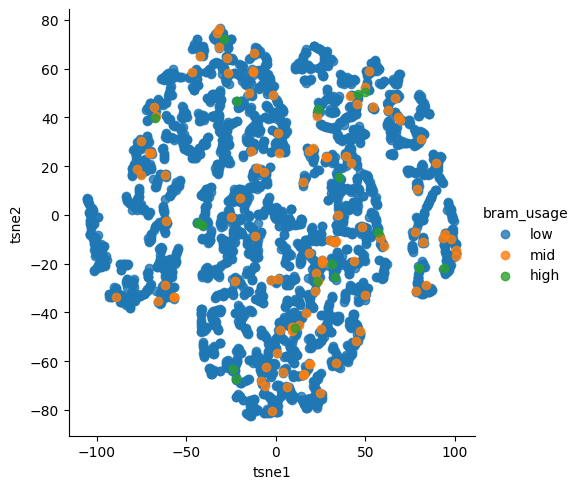

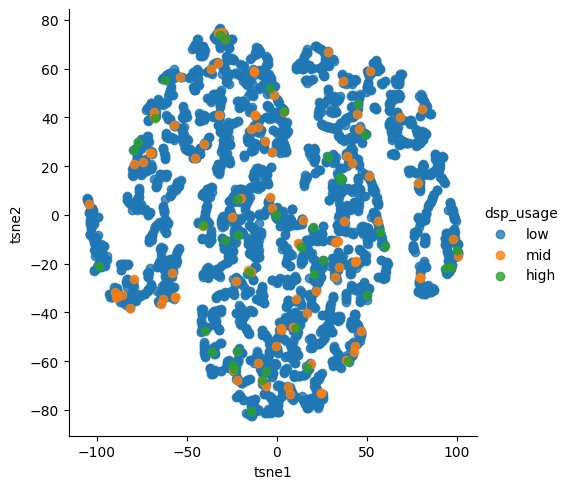

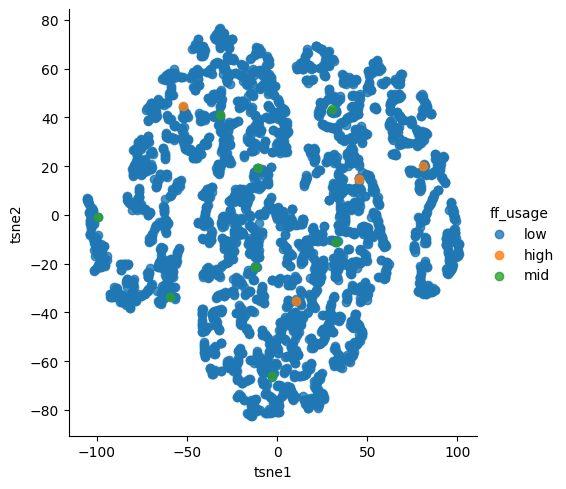

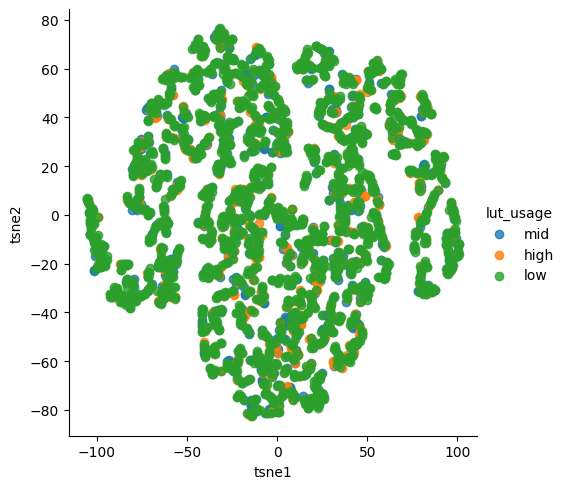

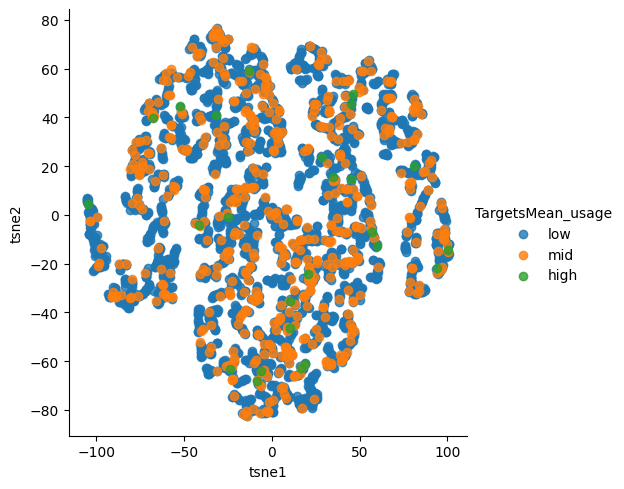

In [10]:
for target_col in target_labels + ['TargetsMean']:
    step = train_df[target_col].max() / kmeans.n_clusters
    resource_thresholds = np.arange(start=0.0, stop=train_df[target_col].max(), step=step)
    # print(resource_thresholds)

    train_df.loc[train_df[target_col] < resource_thresholds[1], f'{target_col}_usage'] = 'low'
    train_df.loc[train_df[target_col] >= resource_thresholds[1], f'{target_col}_usage'] = 'mid'
    train_df.loc[train_df[target_col] >= resource_thresholds[2], f'{target_col}_usage'] = 'high'
    # train_df.head()

    fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_, f'{target_col}_usage': train_df[f'{target_col}_usage']})
    sns.lmplot(data=fr, x='tsne1', y='tsne2', hue=f'{target_col}_usage', fit_reg=False)

# Preprocessing

### Targets Normalization

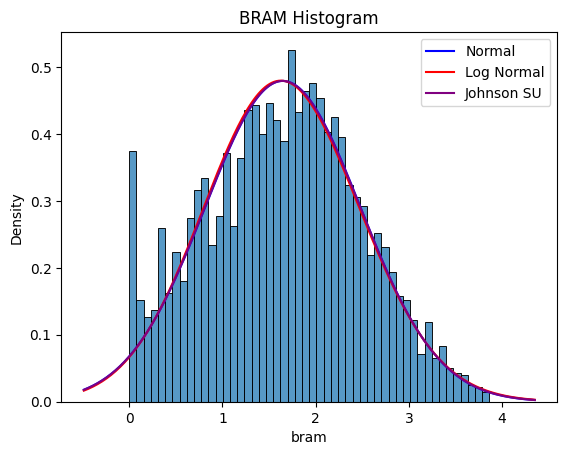

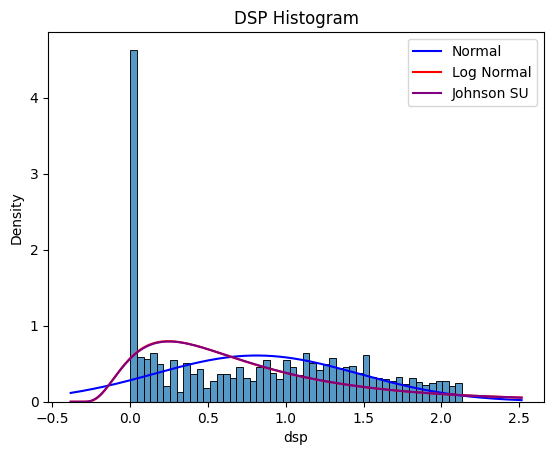

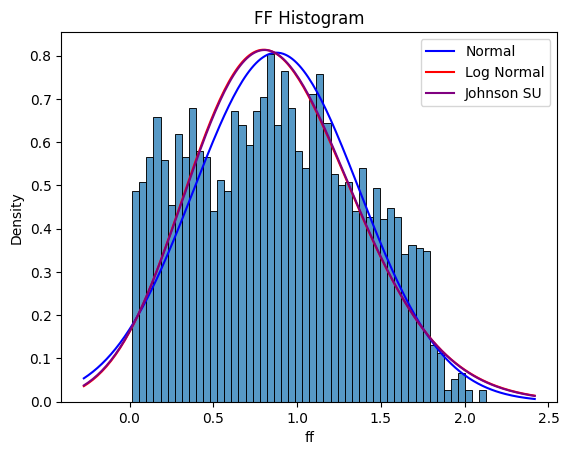

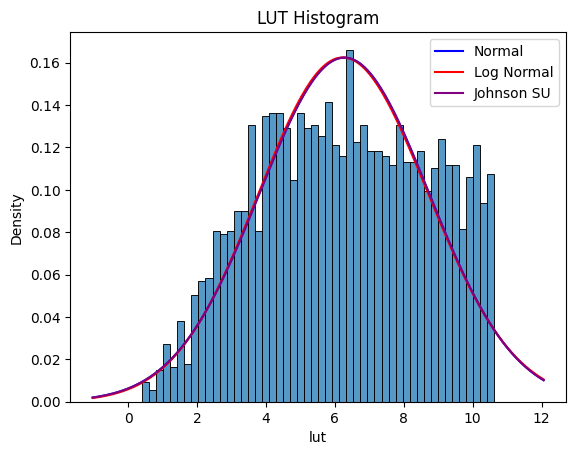

In [12]:
log_norm = lambda x: np.log(1 + x)
boxcox_norm = lambda x: stats.boxcox(x + 1)
johnson_norm = lambda x: np.log(1 + x) / np.log((1 + x) / 2)
# def johnson_norm(x):
#     params = stats.johnsonsu.fit(x)
#     normed = stats.johnsonsu(*params).cdf(x)
#     return normed

train_df[target_labels] = org_train_targets
test_df[target_labels] = org_test_targets

# train_df[target_labels] = train_df[target_labels].apply(log_norm)
# test_df[target_labels] = test_df[target_labels].apply(log_norm)

train_bc_lambda = {}
test_bc_lambda = {}
for idx, label in enumerate(target_labels):
    train_df[label], train_bc_lambda[label] = boxcox_norm(train_df[label])
    test_df[label], test_bc_lambda[label] = boxcox_norm(test_df[label])  
    
    plt.figure(idx)
    plt.title(f'{label.upper()} Histogram')
    ax = sns.histplot(train_df[label], bins=50, kde=False, stat='density')
    add_fit_to_histplot(train_df[label], fit=stats.norm, ax=ax, color='blue', label='Normal')
    add_fit_to_histplot(train_df[label], fit=stats.lognorm, ax=ax, color='red', label='Log Normal')
    add_fit_to_histplot(train_df[label], fit=stats.johnsonsu, ax=ax, color='purple', label='Johnson SU')
    plt.legend()

### Features Normalization

/home/hamza/Projects/NN_stuff/env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4905: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))
/home/hamza/Projects/NN_stuff/env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4905: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))
/home/hamza/Projects/NN_stuff/env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4905: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))
/home/hamza/Projects/NN_stuff/env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4905: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))
/home/hamza/Projects/NN_stuff/env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4905: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np

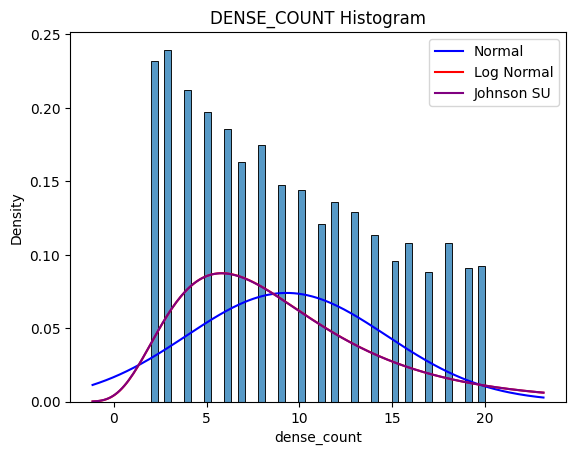

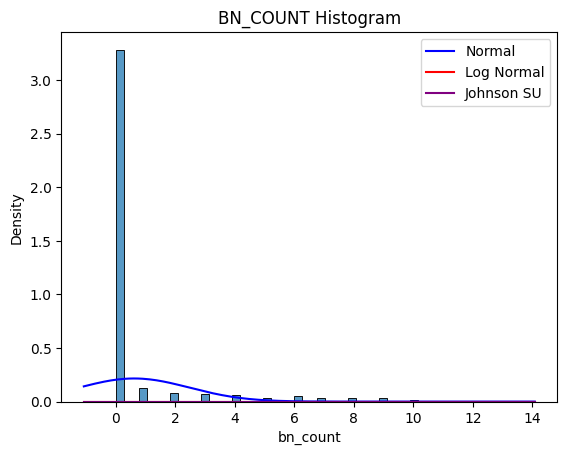

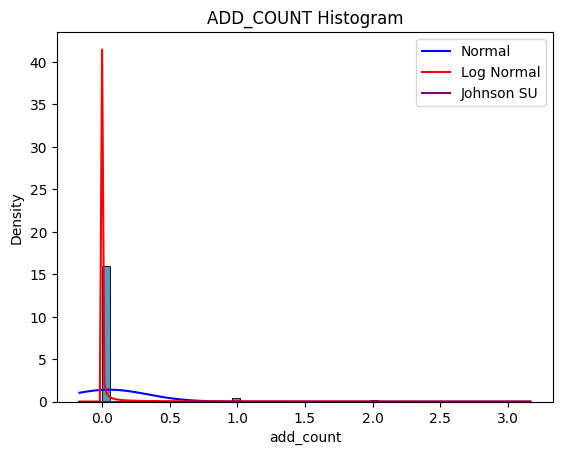

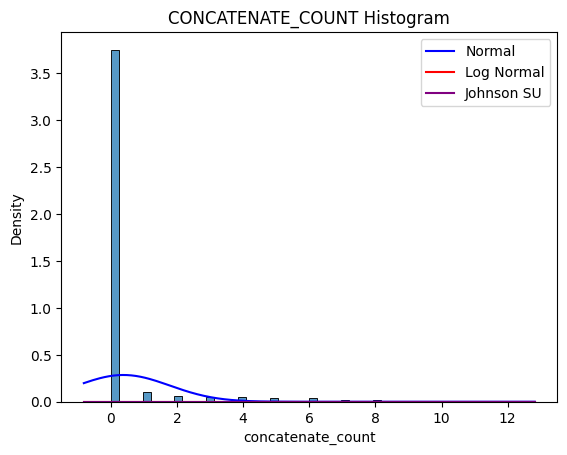

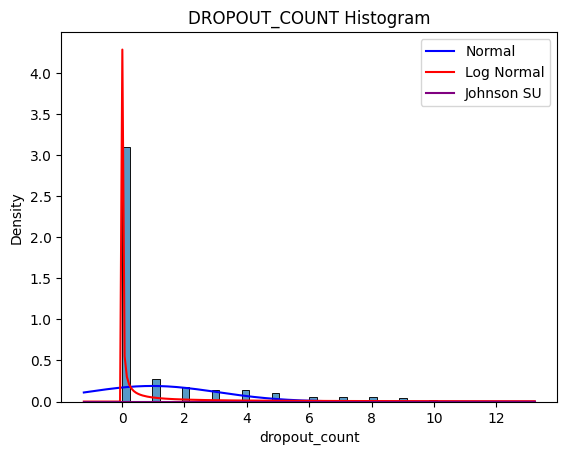

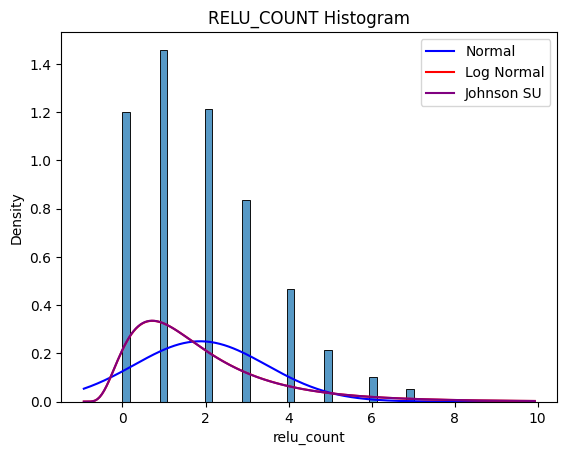

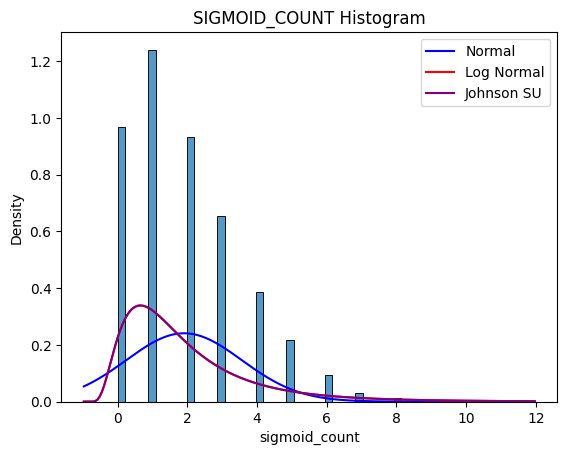

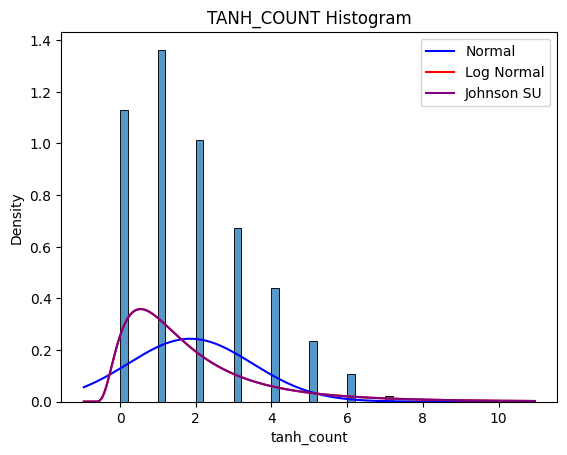

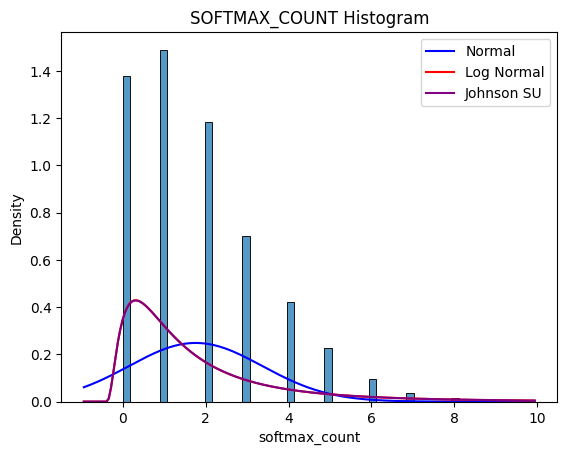

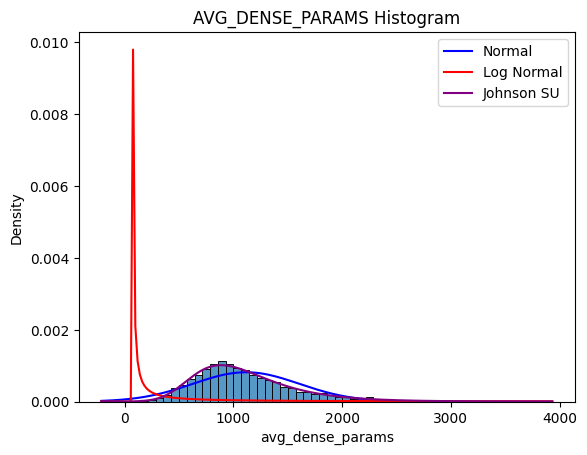

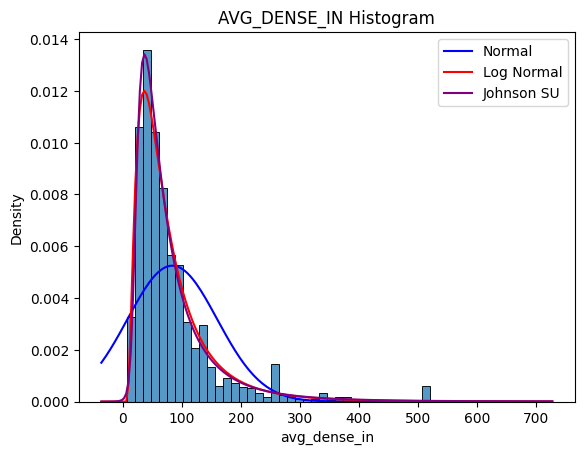

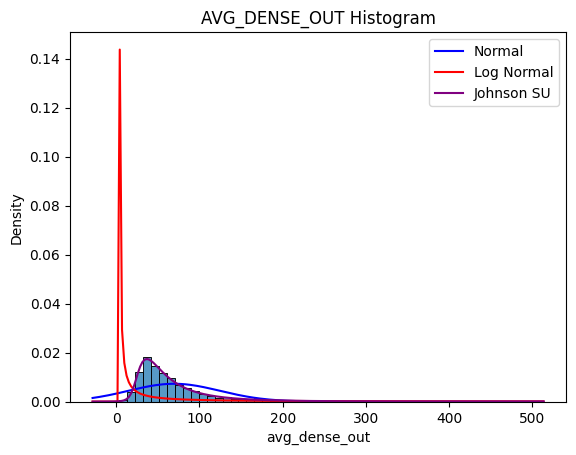

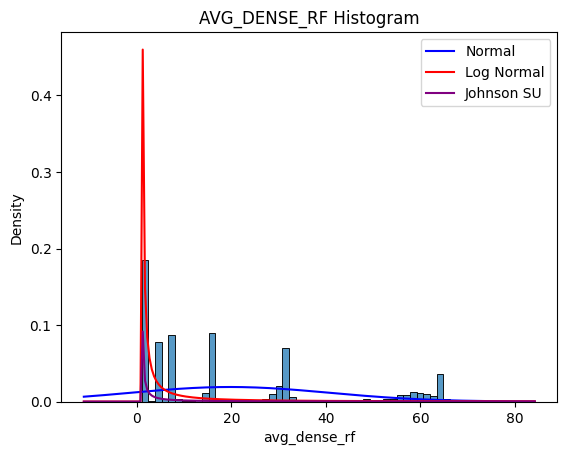

In [13]:
train_df[quantitative_feature_labels] = org_train_quantitative
test_df[quantitative_feature_labels] = org_test_quantitative

for idx, label in enumerate(quantitative_feature_labels):
    plt.figure(idx)
    plt.title(f'{label.upper()} Histogram')
    ax = sns.histplot(train_df[label], bins=50, kde=False, stat='density')
    add_fit_to_histplot(train_df[label], fit=stats.norm, ax=ax, color='blue', label='Normal')
    add_fit_to_histplot(train_df[label], fit=stats.lognorm, ax=ax, color='red', label='Log Normal')
    add_fit_to_histplot(train_df[label], fit=stats.johnsonsu, ax=ax, color='purple', label='Johnson SU')
    plt.legend()

add_count            6.216172
concatenate_count    4.435906
bn_count             3.549737
avg_dense_out        2.991822
avg_dense_in         2.945777
dropout_count        2.540920
avg_dense_params     1.147256
avg_dense_rf         1.036194
softmax_count        1.032909
sigmoid_count        0.994911
tanh_count           0.962129
relu_count           0.903444
dense_count          0.393956
dtype: float64


/home/hamza/Projects/NN_stuff/env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4905: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))
/home/hamza/Projects/NN_stuff/env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4905: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))
/home/hamza/Projects/NN_stuff/env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4905: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))
/home/hamza/Projects/NN_stuff/env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4905: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))


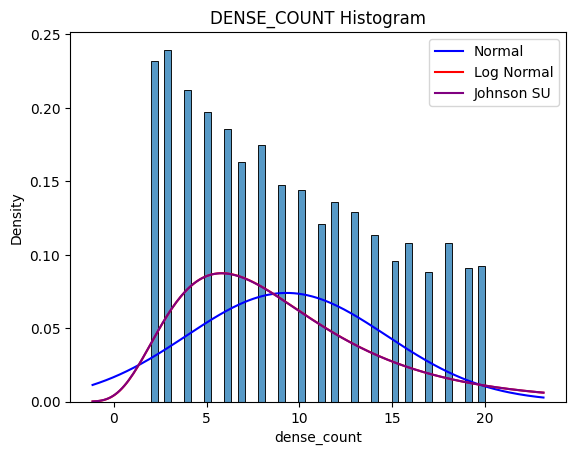

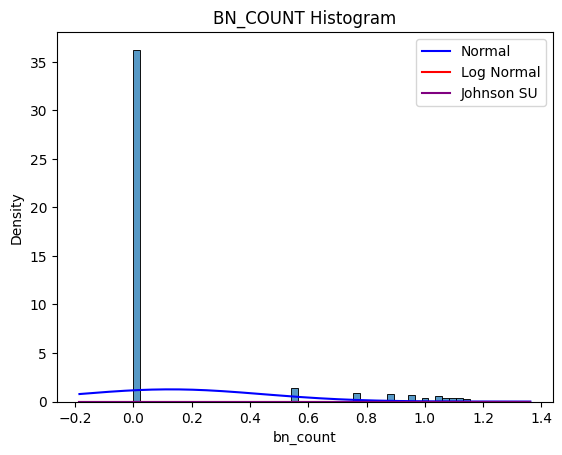

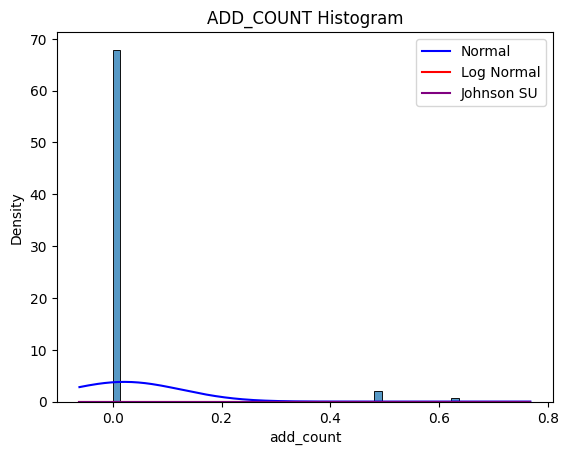

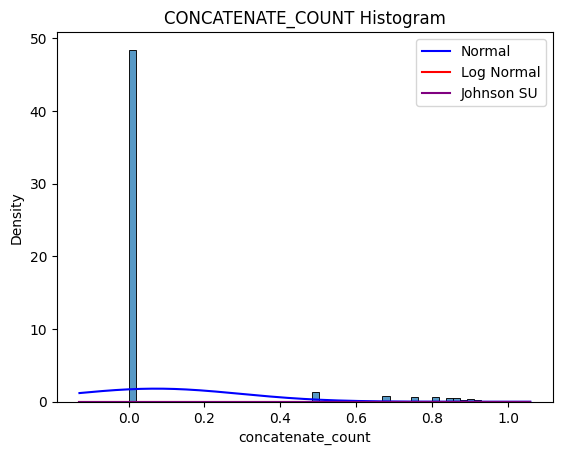

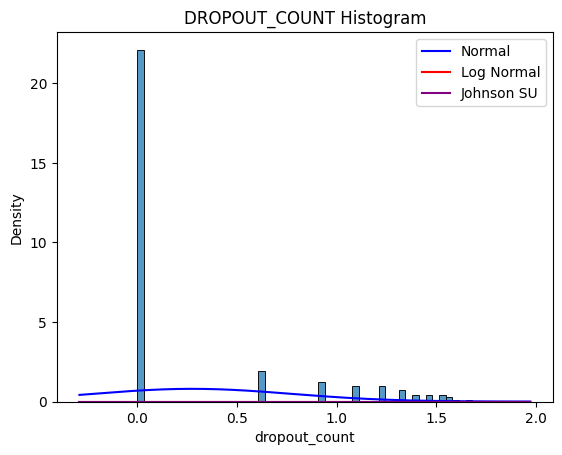

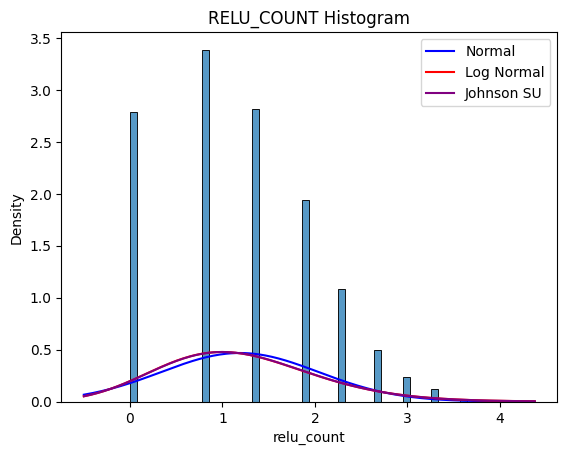

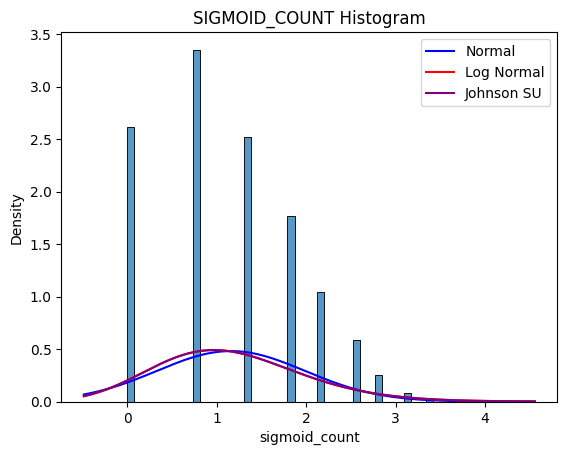

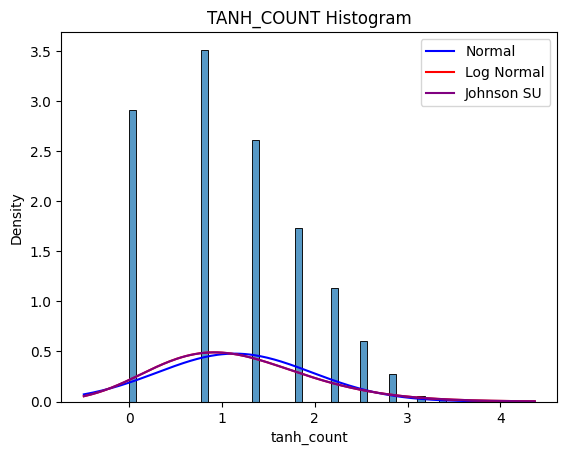

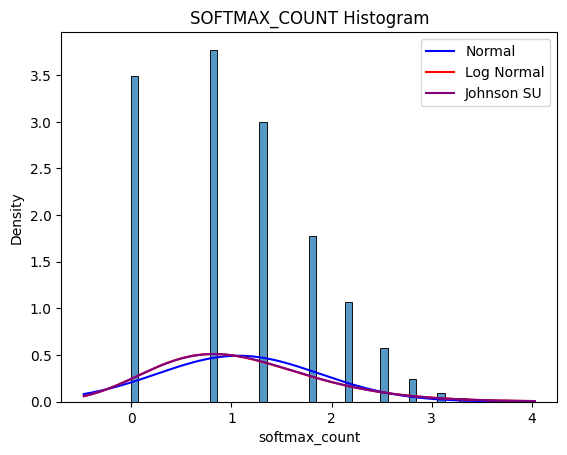

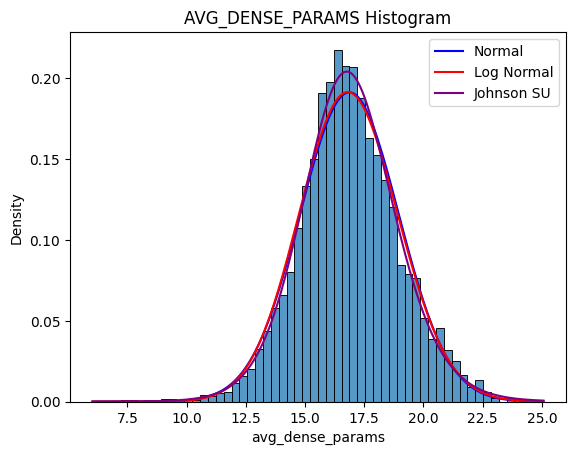

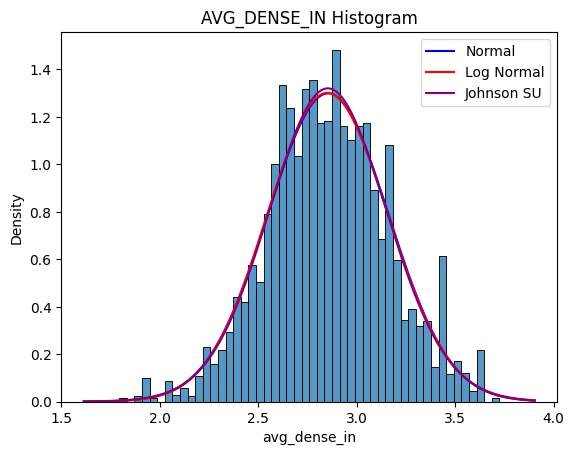

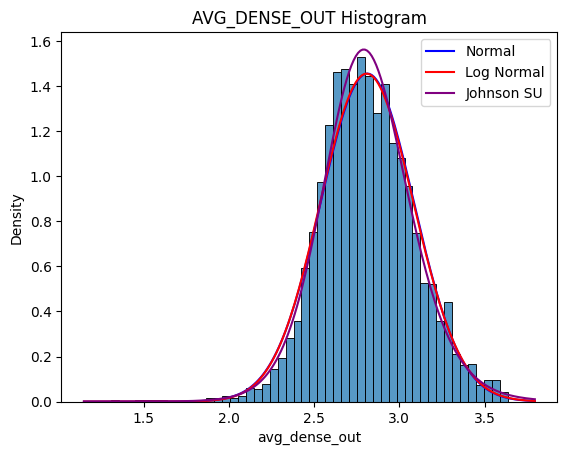

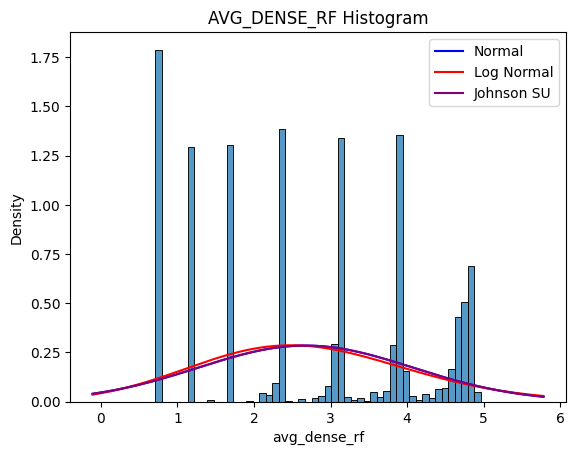

In [14]:
skew_features = train_df[quantitative_feature_labels].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
print(skew_features)

high_skew = skew_features[skew_features.abs() > 0.5]
for col in high_skew.index:
    train_df[col] = boxcox1p(train_df[col], stats.boxcox_normmax(train_df[col] + 1))

skew_features = test_df[quantitative_feature_labels].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
high_skew = skew_features[skew_features.abs() > 0.5]
for col in high_skew.index:
    test_df[col] = boxcox1p(test_df[col], stats.boxcox_normmax(test_df[col] + 1))

for idx, label in enumerate(quantitative_feature_labels):
    plt.figure(idx)
    plt.title(f'{label.upper()} Histogram')
    ax = sns.histplot(train_df[label], bins=50, kde=False, stat='density')
    add_fit_to_histplot(train_df[label], fit=stats.norm, ax=ax, color='blue', label='Normal')
    add_fit_to_histplot(train_df[label], fit=stats.lognorm, ax=ax, color='red', label='Log Normal')
    add_fit_to_histplot(train_df[label], fit=stats.johnsonsu, ax=ax, color='purple', label='Johnson SU')
    plt.legend()

# Regression & Stacking

### ML Regression

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=0)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def mae(y, y_pred):
    return np.abs(y - y_pred)

def cv_rmse(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfolds))
    return rmse

def cv_mae(model, X, y):
    mae = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kfolds)
    return mae

In [ ]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [ ]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=10000000, alphas=alphas2, random_state=0, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=10000000, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003,))

In [ ]:
gbr = GradientBoostingRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=4,
    max_features='sqrt',
    min_samples_leaf=15,
    min_samples_split=10,
    loss='huber',
    random_state=0
)

In [ ]:
lightgbm = LGBMRegressor(
    objective='regression', 
    num_leaves=4,
    learning_rate=0.01, 
    n_estimators=5000,
    max_bin=200, 
    bagging_fraction=0.75,
    bagging_freq=5, 
    bagging_seed=7,
    feature_fraction=0.2,
    feature_fraction_seed=7,
    verbose=-1,
)

In [ ]:
xgboost = XGBRegressor(
    learning_rate=0.01,
    n_estimators=3460,
    max_depth=3,
    min_child_weight=0,
    gamma=0,
    subsample=0.7,
    colsample_bytree=0.7,
    objective='reg:linear',
    nthread=-1,
    scale_pos_weight=1,
    seed=0,
    reg_alpha=0.00006
)

In [ ]:
stack_gen = StackingCVRegressor(
    regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
    meta_regressor=xgboost,
    use_features_in_secondary=True
)

In [ ]:
X = train_df[quantitative_feature_labels + qualitative_labels_encoded]
y = train_df['lut']

score = cv_rmse(ridge, X, y)
score = cv_rmse(lasso, X, y)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = cv_rmse(elasticnet, X, y)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = cv_rmse(svr, X, y)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = cv_rmse(lightgbm, X, y)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = cv_rmse(gbr, X, y)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = cv_rmse(xgboost, X, y)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

In [ ]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

In [ ]:
def blend_models_predict(X):
    return (
        (0.1 * elastic_model_full_data.predict(X)) +\
        (0.05 * lasso_model_full_data.predict(X)) +\
        (0.1 * ridge_model_full_data.predict(X)) +\
        (0.1 * svr_model_full_data.predict(X)) +\
        (0.1 * gbr_model_full_data.predict(X)) +\
        (0.15 * xgb_model_full_data.predict(X)) +\
        (0.1 * lgb_model_full_data.predict(X)) +\
        (0.3 * stack_gen_model.predict(np.array(X)))
    )

print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

In [ ]:
X_test = test_df[quantitative_feature_labels + qualitative_labels_encoded]
y_test = test_df['lut']

predictions = np.expm1(blend_models_predict(X_test))
y_test = np.expm1(y_test)

print(rmsle(y_test, predictions))

prediction_errors = np.abs(predictions - y_test)
print(prediction_errors.mean())
bin_width = 10
num_bins = int(np.ceil(prediction_errors.max() / bin_width))

plt.figure(figsize=(8, 6))
plt.hist(prediction_errors, bins=num_bins, range=(0, prediction_errors.max()), edgecolor='black')
plt.xlabel('Error (%)')
plt.ylabel('Frequency')
plt.title('LUT MAE (%)')
plt.xticks(np.arange(0, prediction_errors.max() + 1, step=bin_width))

plt.show()

### Neural Networks

In [15]:
target = 'lut'
train_df[quantitative_feature_labels + qualitative_labels_encoded + [target]].head()

,dense_count,bn_count,add_count,concatenate_count,dropout_count,relu_count,sigmoid_count,tanh_count,softmax_count,avg_dense_params,avg_dense_in,avg_dense_out,avg_dense_rf,strategy_E,precision_E,board_E,lut
0,3,0.0,0.0,0.0,0.0,0.000000,1.355013,0.000000,0.000000,16.358859,2.587555,2.527671,2.365507,1.0,3.0,3.0,8.380887
1,8,0.0,0.0,0.0,0.0,0.804431,1.810461,1.358910,0.785417,17.940890,3.282346,2.842360,4.726325,2.0,3.0,2.0,9.273794
2,5,0.0,0.0,0.0,0.0,1.395553,0.789970,0.000000,1.342369,18.728217,2.934423,2.947922,3.935482,2.0,2.0,2.0,7.048430
3,6,0.0,0.0,0.0,0.0,0.804431,1.355013,0.791369,0.785417,19.815234,2.716194,2.673797,2.365507,1.0,3.0,2.0,8.287302
4,7,0.0,0.0,0.0,0.0,0.804431,0.789970,1.358910,0.785417,15.937838,3.258607,2.687291,4.556468,1.0,4.0,1.0,4.207310


In [16]:
test_df[quantitative_feature_labels + qualitative_labels_encoded + [target]].head()

,dense_count,bn_count,add_count,concatenate_count,dropout_count,relu_count,sigmoid_count,tanh_count,softmax_count,avg_dense_params,avg_dense_in,avg_dense_out,avg_dense_rf,strategy_E,precision_E,board_E,lut
0,17,0.000000,0.0,0.0,1.538850,2.573852,2.214750,2.243111,0.799269,19.180477,2.944199,2.774286,1.622908,2.0,3.0,3.0,6.939814
1,12,0.000000,0.0,0.0,1.323597,1.365507,0.792333,0.796457,2.950344,18.733407,2.968131,2.760993,4.265810,1.0,2.0,1.0,2.745235
2,2,0.000000,0.0,0.0,0.000000,0.793733,0.000000,0.000000,0.000000,23.480927,3.211585,3.085093,0.695638,1.0,4.0,2.0,3.982435
3,12,0.862092,0.0,0.0,0.000000,2.224348,1.821757,0.796457,0.000000,20.112673,3.298645,3.002564,3.560498,2.0,1.0,3.0,6.569505
4,16,0.000000,0.0,0.0,0.000000,0.793733,1.361599,2.598288,1.855171,16.640243,2.881321,2.435651,1.104877,2.0,4.0,2.0,6.853077


In [17]:
from estimation import DenseSettings, train_dense_model, dense_hp_search

quant = train_df[quantitative_feature_labels].values
# qual = train_df[qualitative_labels_encoded].drop('board_E', axis=1).values
qual = train_df[qualitative_labels_encoded].values
X_train = np.concatenate((qual, quant), axis=-1)
y_train = train_df[target].values
if y_train.ndim == 1:
    y_train = np.expand_dims(y_train, axis=-1)

# train_df[quantitative_feature_labels + qualitative_labels_encoded]
# print(X_train)
# print(y_train)

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
print(input_shape)
print(output_shape)

# tuner = dense_hp_search(X_train, y_train, input_shape=input_shape, output_shape=output_shape)
# print(tuner.results_summary())

(16,)
(1,)


In [18]:
model = train_dense_model(X_train, y_train, input_shape=input_shape, output_shape=output_shape, test=False)

2024-03-07 16:21:07.913979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 16:21:07.948660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 16:21:07.948994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 16:21:07.953205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 16:21:07.953678: I tensorflow/compile

Model: "NN-estim"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 numerical_in (InputLayer)   [(None, 13)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   832       ['numerical_in[0][0]']        
                                                                                                  
 strategy (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 precision (InputLayer)      [(None, 1)]                  0         []                            
                                                                                           

2024-03-07 16:21:10.447003: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x9f26190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 16:21:10.447047: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-03-07 16:21:10.452073: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-07 16:21:10.468172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-03-07 16:21:10.579293: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


899/899 [==============================] - 19s 17ms/step - loss: 1.8313 - n_mae_bram: 0.9156 - mape_bram: 39.0295 - val_loss: 1.2750 - val_n_mae_bram: 0.6375 - val_mape_bram: 21.3841
Epoch 2/20
899/899 [==============================] - 15s 17ms/step - loss: 1.2116 - n_mae_bram: 0.6058 - mape_bram: 21.6663 - val_loss: 1.1490 - val_n_mae_bram: 0.5745 - val_mape_bram: 19.2304
Epoch 3/20
899/899 [==============================] - 15s 17ms/step - loss: 1.1488 - n_mae_bram: 0.5744 - mape_bram: 20.1975 - val_loss: 1.1242 - val_n_mae_bram: 0.5621 - val_mape_bram: 19.7690
Epoch 4/20
899/899 [==============================] - 15s 17ms/step - loss: 1.0962 - n_mae_bram: 0.5481 - mape_bram: 19.0760 - val_loss: 1.0652 - val_n_mae_bram: 0.5326 - val_mape_bram: 18.4653
Epoch 5/20
899/899 [==============================] - 15s 17ms/step - loss: 1.0352 - n_mae_bram: 0.5176 - mape_bram: 18.0829 - val_loss: 0.9731 - val_n_mae_bram: 0.4865 - val_mape_bram: 17.1344
Epoch 6/20
899/899 [=====================

[[22.32011904]]
1/1 [==============================] - 0s 146ms/step
[[1030621.25]]
[[64.25736534]]
1/1 [==============================] - 0s 31ms/step
[[80483.33]]
[[22.32011904]]
1/1 [==============================] - 0s 27ms/step
[[166765.34]]
[[7.42078381]]
1/1 [==============================] - 0s 30ms/step
[[311545.6]]
[[5.56264446]]
1/1 [==============================] - 0s 34ms/step
[[1049.6099]]
[[3.40953696]]
1/1 [==============================] - 0s 35ms/step
[[327.89227]]
[[9.99251948]]
1/1 [==============================] - 0s 32ms/step
[[6894.424]]
[[2.89760767]]
1/1 [==============================] - 0s 30ms/step
[[66.16081]]
[[5.84744322]]
1/1 [==============================] - 0s 39ms/step
[[7292.669]]
[[3.23816541]]
1/1 [==============================] - 0s 30ms/step
[[27.108515]]
[[131.18015891]]
1/1 [==============================] - 0s 31ms/step
[[403397.5]]
[[25.30608862]]
1/1 [==============================] - 0s 30ms/step
[[75493.04]]
[[27.35103496]]
1/1 [======

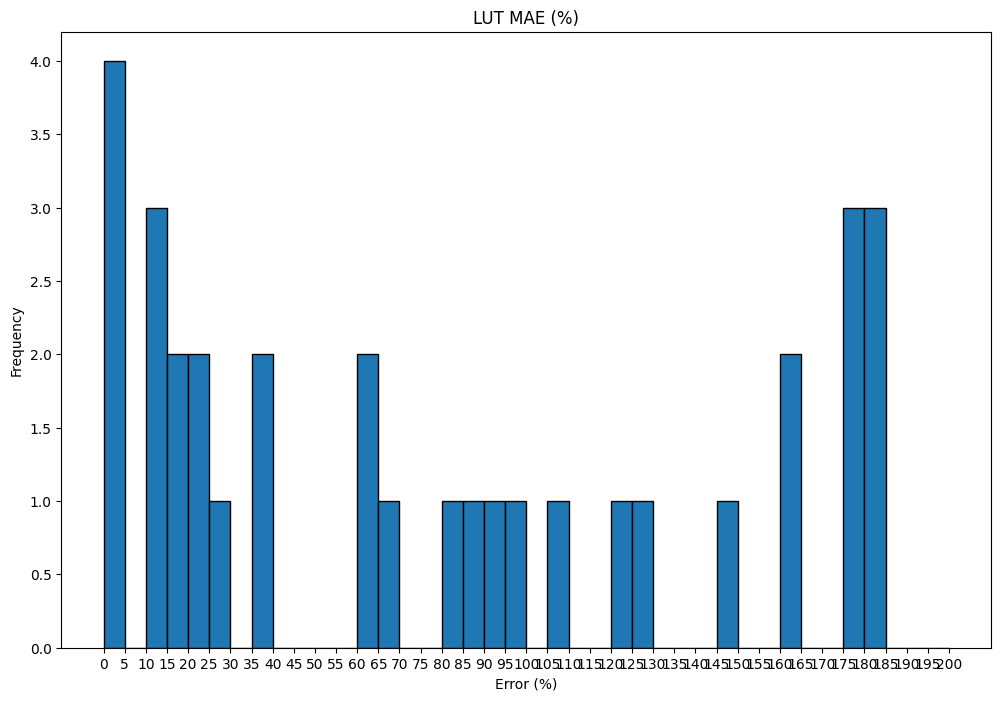

In [19]:
from estimation import prepare_simple_dataset

quant_test = test_df[quantitative_feature_labels].values
# qual_test = test_df[qualitative_labels_encoded].drop('board_E', axis=1).values
qual_test = test_df[qualitative_labels_encoded].values
X_test = np.concatenate((qual_test, quant_test), axis=-1)
y_test = test_df['bram'].values
if y_test.ndim == 1:
    y_test = np.expand_dims(y_test, axis=-1)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'strategy': X_test[:, 0],
        'precision': X_test[:, 1],
        'board': X_test[:, 2],
        'numerical_in': X_test[:, 3:],
    },
    y_test
))
test_dataset = test_dataset.shuffle(len(test_dataset)).batch(1)

ground_truth = []
predictions = []
for (inputs, targets) in test_dataset.as_numpy_iterator():
    # targets = np.expm1(targets)
    targets = inv_boxcox(targets, test_bc_lambda[target])
    print(targets)
    ground_truth.append(targets)
    
    # predictions.append(np.expm1(model.predict(inputs, 0)))
    predictions.append(inv_boxcox(model.predict(inputs, 0), test_bc_lambda[target]))
    print(predictions[-1])

ground_truth = np.squeeze(np.asarray(ground_truth))
predictions = np.squeeze(np.asarray(predictions))

prediction_errors = np.abs(predictions - ground_truth)
print(prediction_errors)

bin_width = 5
num_bins = int(np.ceil(200. / bin_width))

plt.figure(figsize=(12, 8))
plt.hist(prediction_errors, bins=num_bins, range=(0, 200.), edgecolor='black')
plt.xlabel('Error (%)')
plt.ylabel('Frequency')
plt.title('LUT MAE (%)')
plt.xticks(np.arange(0, 200. + 1, step=bin_width))

plt.show()

In [ ]:
# def train_rf(train_data, test_data):
#     rf = tfdf.keras.RandomForestModel(
#         hyperparameter_template='benchmark_rank1',
#         task=tfdf.keras.Task.REGRESSION,
#     )
#     rf.compile(metrics=['mse', 'mae'])
#     rf.fit(x=train_data)
    
#     evaluation = rf.evaluate(x=test_data)
#     return rf, evaluation

# batch_size = 1024
# train_data = tf.data.Dataset.from_tensor_slices((
#     {
#         'strategy': inputs[:, 0],
#         'precision': inputs[:, 1],
#         'board': inputs[:, 2],
#         'dense_count': inputs[:, 3],
#         'bn_count': inputs[:, 4],
#         'add_count': inputs[:, 5],
#         'concatenate_count': inputs[:, 6],
#         'dropout_count': inputs[:, 7],
#         'relu_count': inputs[:, 8],
#         'sigmoid_count': inputs[:, 9],
#         'tanh_count': inputs[:, 10],
#         'softmax_count': inputs[:, 11],
#         'avg_dense_params': inputs[:, 12],
#         'avg_dense_in': inputs[:, 13],
#         'avg_dense_out': inputs[:, 14],
#         'avg_dense_rf': inputs[:, 15]
#     },
#     targets
# )).batch(batch_size)

# test_data = tf.data.Dataset.from_tensor_slices((
#     {
#         'strategy': test_inputs[:, 0],
#         'precision': test_inputs[:, 1],
#         'board': test_inputs[:, 2],
#         'dense_count': test_inputs[:, 3],
#         'bn_count': test_inputs[:, 4],
#         'add_count': test_inputs[:, 5],
#         'concatenate_count': test_inputs[:, 6],
#         'dropout_count': test_inputs[:, 7],
#         'relu_count': test_inputs[:, 8],
#         'sigmoid_count': test_inputs[:, 9],
#         'tanh_count': test_inputs[:, 10],
#         'softmax_count': test_inputs[:, 11],
#         'avg_dense_params': test_inputs[:, 12],
#         'avg_dense_in': test_inputs[:, 13],
#         'avg_dense_out': test_inputs[:, 14],
#         'avg_dense_rf': test_inputs[:, 15]
#     },
#     test_targets
# )).batch(1)

# rf, evaluation = train_rf(train_data, test_data)

# inspector = rf.make_inspector()
# logs = inspector.training_logs()
# plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
# plt.xlabel('Number of trees')
# plt.ylabel('RMSE (out-of-bag)')

# inspector.evaluation()
# print('Available variable importances:')
# for importance in inspector.variable_importances().keys():
#     print(importance)
#     print('\t', inspector.variable_importances()[importance])


# for inputs, targets in test_data.as_numpy_iterator():
#     print(targets)
#     print(rf.predict(inputs))

# prediction_errors = np.abs(rf.predict(test_data) - test_targets)
# # print(prediction_errors)
# bin_width = 5
# num_bins = int(np.ceil(200. / bin_width))

# plt.figure(figsize=(8, 6))
# plt.hist(prediction_errors, bins=num_bins, range=(0, 200.), edgecolor='black')
# plt.xlabel('Error (%)')
# plt.ylabel('Frequency')
# plt.title('LUT MAE (%)')
# plt.xticks(np.arange(0, 200. + 1, step=bin_width))

# plt.show()